In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import glob

from scipy.stats import pointbiserialr, spearmanr, pearsonr, chi2_contingency, zscore

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mutual_info_score

from IPython.display import clear_output
clear_output()

In [2]:
cctrans = pd.read_csv('(Cleaned) Data/CCTRANSACTIONS_Q42023_Q12024.csv')
ibft = pd.read_csv('(Cleaned) Data/IBFT_OUTGOING_Q42023_Q12024.csv')
products = pd.read_csv('(Cleaned) Data/PRODUCTS_Q42023_Q12024.csv')
segments = pd.read_csv('(Cleaned) Data/SEGMENTS_Q42023_Q12024.csv')

### **IBFT**

In [3]:
ibft

,CUSTOMER_ID,ACCOUNT_ID,RECEIVING_ALIEN_ID,RECEIVING_BANK_CODE,TRANSACTION_AMOUNT,TRANSACTION_DATE
0,4.919560e+07,8.940830e+07,3.061918e+06,BANK 1,12501.67,2023-10-01
1,2.936154e+07,8.390155e+07,3.177228e+06,BANK 2,3000.74,2023-10-01
2,1.308383e+08,3.977686e+07,1.031828e+06,BANK 2,17999.80,2023-10-01
3,4.389536e+07,5.691287e+07,5.076808e+06,BANK 3,9999.85,2023-10-01
4,2.693906e+07,5.886424e+07,3.574430e+06,BANK 2,2000.92,2023-10-01
...,...,...,...,...,...,...
339938,3.838652e+07,8.644802e+07,5.988383e+06,BANK 51,143.34,2024-03-10
339939,5.903460e+07,1.094282e+08,6.277682e+06,BANK 51,30000.42,2024-03-25
339940,5.903460e+07,1.094282e+08,6.277682e+06,BANK 51,20000.41,2024-03-24
339941,5.903460e+07,1.094282e+08,6.277682e+06,BANK 51,20000.85,2024-03-23


In [4]:
# Convert TRANSACTION_DATE to datetime
ibft['TRANSACTION_DATE'] = pd.to_datetime(ibft['TRANSACTION_DATE'])

# Extract quarter
ibft['QUARTER'] = ibft['TRANSACTION_DATE'].dt.to_period('Q')

# Group by CUSTOMER_ID and QUARTER, then sum TRANSACTION_AMOUNT
aggregated_ibft = ibft.groupby(['CUSTOMER_ID', 'QUARTER']).agg({'TRANSACTION_AMOUNT': 'sum'}).reset_index()

# Format QUARTER column
aggregated_ibft['QUARTER'] = aggregated_ibft['QUARTER'].apply(lambda x: f'Q{x.quarter} {x.year}')

# Rename the column
aggregated_ibft = aggregated_ibft.rename(columns={'TRANSACTION_AMOUNT': 'TRANSACTION_AMOUNT_IBFT'})

ibft = aggregated_ibft

### **Products**

In [5]:
products

,CUSTOMER_ID,SAVINGS_ACCOUNT_INDICATOR,CHECKING_ACCOUNT_INDICATOR,TIME_DEPOSIT_ACCOUNT_INDICATOR,AUTO_LOAN_INDICATOR,HOUSING_LOAN_INDICATOR,PERSONAL_LOAN_INDICATOR,BB_LOAN_INDICATOR,LIFE_INSURANCE_INDICATOR,NONLIFE_INSURANCE_INDICATOR,INVESTMENT_INDICATOR,CURRENT_MONTH
0,4.302857e+03,1,0,0,0,0,0,0,0,0,0,10/2023
1,4.915714e+03,1,0,0,0,0,0,0,0,0,0,10/2023
2,5.658571e+03,1,0,0,0,0,0,0,1,0,0,10/2023
3,8.045714e+03,0,0,0,0,0,0,0,0,0,0,10/2023
4,1.047429e+04,0,0,0,0,0,0,0,1,0,0,10/2023
...,...,...,...,...,...,...,...,...,...,...,...,...
522404,1.428346e+08,1,0,0,0,0,0,0,0,0,0,03/2024
522405,1.428414e+08,0,0,0,0,0,0,0,0,0,0,03/2024
522406,1.428492e+08,1,1,0,0,0,1,1,1,0,0,03/2024
522407,1.428498e+08,0,0,0,0,0,0,0,0,0,0,03/2024


In [6]:
# Convert CURRENT_MONTH to datetime
products['CURRENT_MONTH'] = pd.to_datetime(products['CURRENT_MONTH'], format='%m/%Y')

# Extract quarter
products['QUARTER'] = products['CURRENT_MONTH'].dt.to_period('Q')

# Group by CUSTOMER_ID and QUARTER, then sum the specified columns
aggregated_products = products.groupby(['CUSTOMER_ID', 'QUARTER']).agg({
    'AUTO_LOAN_INDICATOR': 'sum',
    'HOUSING_LOAN_INDICATOR': 'sum',
    'SAVINGS_ACCOUNT_INDICATOR': 'sum'
}).reset_index()

# Format QUARTER column
aggregated_products['QUARTER'] = aggregated_products['QUARTER'].apply(lambda x: f'Q{x.quarter} {x.year}')

# Display the updated dataframe
products = aggregated_products

### **Segments**

In [7]:
segments

,CUSTOMER_ID,CUSTOMER_GROUP,CUSTOMER_SEGMENT
0,1.371880e+08,RETAIL,Tier 6
1,7.363929e+07,RETAIL,Tier 6
2,6.190229e+07,RETAIL,Tier 6
3,6.333086e+07,RETAIL,Tier 6
4,3.761657e+07,RETAIL,Tier 6
...,...,...,...
99995,1.858279e+07,BUSINESS BANKING,NaN
99996,5.800595e+07,BUSINESS BANKING,NaN
99997,7.410509e+07,BUSINESS BANKING,NaN
99998,1.393309e+08,BUSINESS BANKING,NaN


In [8]:
# Drop the 'CUSTOMER_GROUP' column from the segments dataframe
segments = segments.drop(columns=['CUSTOMER_GROUP'])

# Remove rows where CUSTOMER_SEGMENT is null
segments = segments.dropna(subset=['CUSTOMER_SEGMENT'])

segments

,CUSTOMER_ID,CUSTOMER_SEGMENT
0,1.371880e+08,Tier 6
1,7.363929e+07,Tier 6
2,6.190229e+07,Tier 6
3,6.333086e+07,Tier 6
4,3.761657e+07,Tier 6
...,...,...
89995,1.190235e+08,Tier 4
89996,5.701052e+07,Tier 3
89997,1.142923e+07,Tier 3
89998,2.092495e+07,Tier 3


### **CC Transactions**

In [9]:
cctrans

,CUSTOMER_ID,CC_ACCOUNT_ID,MCC_CODE,TRANSACTION_AMOUNT,TRANSACTION_DATE,CARD_TYPE,CHANNEL
0,1.034364e+08,1.057741e+08,5411,1760.33,2023-10-01,PRE-NUMBERED EXPRESS CASH,PHYSICAL
1,1.030679e+08,6.238838e+07,5734,2719.64,2023-10-01,EMV Gold MC,ONLINE
2,8.738459e+07,4.900106e+07,5399,195.24,2023-10-01,Magstripe-Blue MC,ONLINE
3,1.034364e+08,1.057741e+08,5814,2469.54,2023-10-01,PRE-NUMBERED EXPRESS CASH,PHYSICAL
4,1.096100e+07,4.889572e+07,5814,251.62,2023-10-01,EMV Gold MC,ONLINE
...,...,...,...,...,...,...,...
535487,6.576957e+07,4.644408e+07,5541,4001.03,2024-03-27,EMV Gold MC,PHYSICAL
535488,1.302231e+08,8.134139e+07,5912,1501.13,2024-03-27,EMV Gold MC,PHYSICAL
535489,8.411550e+07,5.596352e+07,4814,199.31,2024-03-27,EMV Blue MC,ONLINE
535490,5.269180e+07,1.067314e+08,4814,2700.51,2024-03-29,BPI Platinum Rewards MC,ONLINE


In [10]:
# Convert TRANSACTION_DATE to datetime
cctrans['TRANSACTION_DATE'] = pd.to_datetime(cctrans['TRANSACTION_DATE'])

# Extract quarter
cctrans['QUARTER'] = cctrans['TRANSACTION_DATE'].dt.to_period('Q')

# Group by CUSTOMER_ID and QUARTER, then sum TRANSACTION_AMOUNT
aggregated_cctrans = cctrans.groupby(['CUSTOMER_ID', 'QUARTER']).agg({
    'TRANSACTION_AMOUNT': 'sum'
}).reset_index()

# Format QUARTER column
aggregated_cctrans['QUARTER'] = aggregated_cctrans['QUARTER'].apply(lambda x: f'Q{x.quarter} {x.year}')

# Rename the column
aggregated_cctrans = aggregated_cctrans.rename(columns={'TRANSACTION_AMOUNT': 'TRANSACTION_AMOUNT_CC'})

cctrans = aggregated_cctrans

### **Debit**

In [11]:
debit = pd.read_csv('(Cleaned) Data/debit_cleaned_aggregated.csv')
debit

,Unnamed: 0,CUSTOMER_ID,TRANSACTION_TYPE,QUARTER,TRANSACTION_AMOUNT
0,0,5.658571e+03,PHYSICAL,Q4 2023,1004.22
1,1,1.063143e+04,PHYSICAL,Q1 2024,114.71
2,2,1.111571e+04,PHYSICAL,Q1 2024,411.84
3,3,1.925857e+04,PHYSICAL,Q1 2024,419.28
4,4,1.925857e+04,PHYSICAL,Q4 2023,928.24
...,...,...,...,...,...
38015,38015,1.428346e+08,PHYSICAL,Q1 2024,6694.59
38016,38016,1.428346e+08,PHYSICAL,Q4 2023,8241.82
38017,38017,1.428492e+08,ONLINE,Q1 2024,418.25
38018,38018,1.428492e+08,PHYSICAL,Q1 2024,40000.07


In [12]:
# Remove the 'Unnamed: 0' and 'TRANSACTION_TYPE' columns from the debit dataframe
debit = debit.drop(columns=['Unnamed: 0', 'TRANSACTION_TYPE'])

# Rename the 'TRANSACTION_AMOUNT' column to 'TRANSACTION_AMOUNT_DEBIT'
debit = debit.rename(columns={'TRANSACTION_AMOUNT': 'TRANSACTION_AMOUNT_DEBIT'})

debit

,CUSTOMER_ID,QUARTER,TRANSACTION_AMOUNT_DEBIT
0,5.658571e+03,Q4 2023,1004.22
1,1.063143e+04,Q1 2024,114.71
2,1.111571e+04,Q1 2024,411.84
3,1.925857e+04,Q1 2024,419.28
4,1.925857e+04,Q4 2023,928.24
...,...,...,...
38015,1.428346e+08,Q1 2024,6694.59
38016,1.428346e+08,Q4 2023,8241.82
38017,1.428492e+08,Q1 2024,418.25
38018,1.428492e+08,Q1 2024,40000.07


### **CDNA**

In [13]:
cdna = pd.read_csv('(Cleaned) Data/cdna_cleaned.csv')
cdna

,Unnamed: 0,CUSTOMER_ID,GENDER,AGE,MARITAL_STATUS,EDUCATION,BANK_TENURE,CUSTOMER_LOCATION,DIGITAL_INDICATOR,SEC,HOME_OWNER_INDICATOR,CAR_OWNER_INDICATOR,MONTHLY_INCOME,INCOME_SOURCE,ENVIRONMENTAL_AFF_INDICATOR,HUMANITARIAN_AFF_INDICATOR,OF_INDICATOR,RETIREES_INDICATOR,FILCHI_INDICATOR
0,0,4.598716e+06,FEMALE,43.67,MARRIED,MID,15.50,REGION VII (CENTRAL VISAYAS),TRADITIONAL,C1,Y,N,59465.23,COMMISSION,N,N,N,N,N
1,1,7.509760e+06,FEMALE,29.74,SINGLE,NO_DATA,2.59,NATIONAL CAPITAL REGION,DIGITAL,C1,Y,N,74533.25,SALARY,N,N,N,N,N
2,2,9.597760e+06,MALE,30.80,SINGLE,NO_DATA,1.92,NATIONAL CAPITAL REGION,DIGITAL,B2,Y,N,102944.40,SALARY,N,N,N,N,N
3,3,1.749770e+07,MALE,31.85,SINGLE,MID,14.47,NATIONAL CAPITAL REGION,DIGITAL,B2,Y,N,115609.09,SALARY,N,N,Y,N,N
4,4,1.758271e+07,FEMALE,53.92,SINGLE,MID,27.25,NATIONAL CAPITAL REGION,DIGITAL,B2,Y,N,128745.85,REMITTANCE,N,N,Y,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89720,91998,1.428473e+08,FEMALE,54.07,SEPARATED,MID,26.28,NO_DATA,NO_DATA,E,N,N,10000.07,ALLOWANCE,N,N,N,N,N
89721,91999,1.428492e+08,FEMALE,41.39,MARRIED,NO_DATA,6.25,REGION XIII (CARAGA),TRADITIONAL,B2,N,N,117034.58,BUSINESS,N,N,N,N,N
89722,92000,1.428498e+08,FEMALE,24.25,SINGLE,NO_DATA,-0.06,NO_DATA,NO_DATA,E,N,N,-0.75,SALARY,N,N,N,N,Y
89723,92001,1.428526e+08,FEMALE,33.07,MARRIED,MID,10.88,REGION X (NORTHERN MINDANAO),NO_DATA,B2,N,N,21665.74,SALARY,N,N,N,N,Y


In [14]:
# Select only the specified columns from the cdna dataframe
cdna = cdna[['CUSTOMER_ID','BANK_TENURE', 'SEC', 'DIGITAL_INDICATOR', 'CUSTOMER_LOCATION', 'AGE', 'GENDER', 'EDUCATION', 'MONTHLY_INCOME']]

cdna

,CUSTOMER_ID,BANK_TENURE,SEC,DIGITAL_INDICATOR,CUSTOMER_LOCATION,AGE,GENDER,EDUCATION,MONTHLY_INCOME
0,4.598716e+06,15.50,C1,TRADITIONAL,REGION VII (CENTRAL VISAYAS),43.67,FEMALE,MID,59465.23
1,7.509760e+06,2.59,C1,DIGITAL,NATIONAL CAPITAL REGION,29.74,FEMALE,NO_DATA,74533.25
2,9.597760e+06,1.92,B2,DIGITAL,NATIONAL CAPITAL REGION,30.80,MALE,NO_DATA,102944.40
3,1.749770e+07,14.47,B2,DIGITAL,NATIONAL CAPITAL REGION,31.85,MALE,MID,115609.09
4,1.758271e+07,27.25,B2,DIGITAL,NATIONAL CAPITAL REGION,53.92,FEMALE,MID,128745.85
...,...,...,...,...,...,...,...,...,...
89720,1.428473e+08,26.28,E,NO_DATA,NO_DATA,54.07,FEMALE,MID,10000.07
89721,1.428492e+08,6.25,B2,TRADITIONAL,REGION XIII (CARAGA),41.39,FEMALE,NO_DATA,117034.58
89722,1.428498e+08,-0.06,E,NO_DATA,NO_DATA,24.25,FEMALE,NO_DATA,-0.75
89723,1.428526e+08,10.88,B2,NO_DATA,REGION X (NORTHERN MINDANAO),33.07,FEMALE,MID,21665.74


### **Loan**

In [15]:
loan = pd.read_csv('(Cleaned) Data/loan_cleaned.csv')
loan

,Unnamed: 0,CUSTOMER_ID,LOAN_AMOUNT,LOAN_BEHAVIOR,LOAN_START_DATE
0,0,1.001572e+07,1000001.67,Amortization Past Due,2010-11-26
1,1,1.242506e+07,699300.74,Items for litigation,2013-09-19
2,2,1.404520e+07,1463999.80,Current,2013-10-03
3,3,9.421564e+07,3779999.85,Current,2014-10-13
4,4,8.624422e+07,1080000.92,Current,2014-12-19
...,...,...,...,...,...
35713,35713,1.187123e+08,15000.73,Current,2024-03-27
35714,35714,1.407766e+08,94999.59,Current,2024-03-27
35715,35715,1.379087e+08,59998.90,Current,2024-03-27
35716,35716,5.796677e+07,130000.85,Current,2024-03-27


In [16]:
# Select only the specified columns from the loan dataframe
loan = loan[['CUSTOMER_ID', 'LOAN_BEHAVIOR', 'LOAN_AMOUNT']]

loan

,CUSTOMER_ID,LOAN_BEHAVIOR,LOAN_AMOUNT
0,1.001572e+07,Amortization Past Due,1000001.67
1,1.242506e+07,Items for litigation,699300.74
2,1.404520e+07,Current,1463999.80
3,9.421564e+07,Current,3779999.85
4,8.624422e+07,Current,1080000.92
...,...,...,...
35713,1.187123e+08,Current,15000.73
35714,1.407766e+08,Current,94999.59
35715,1.379087e+08,Current,59998.90
35716,5.796677e+07,Current,130000.85


### **CCConso**

In [17]:
ccconso = pd.read_csv('(Cleaned) Data/ccconso_cleaned_aggregated.csv')
ccconso 

,Unnamed: 0,CUSTOMER_ID,TOTAL_BALANCE,CURRENT_MONTH_BILLING,PREVIOUS_MONTH_BILLING,REVOLVING_BALANCE,CURRENT_MONTH
0,0,5.962607e+07,1.67,1.67,1.67,1.67,10/2023
1,1,1.240043e+08,0.74,0.74,0.74,0.74,10/2023
2,2,1.240043e+08,-0.20,NaN,NaN,-0.20,10/2023
3,3,1.075312e+08,-0.15,-0.15,-0.15,-0.15,10/2023
4,4,7.303243e+07,369531.38,0.92,147985.30,142077.92,10/2023
...,...,...,...,...,...,...,...
143160,143160,5.132595e+07,32836.45,32481.45,90284.25,-0.91,03/2024
143161,143161,5.132595e+07,11245.01,11245.01,0.51,0.51,03/2024
143162,143162,5.132595e+07,0.57,0.57,0.57,0.57,03/2024
143163,143163,5.132595e+07,8564.69,8574.69,15270.07,1.34,03/2024


In [18]:
# Select only the specified columns from the ccconso dataframe
ccconso = ccconso[['CUSTOMER_ID', 'TOTAL_BALANCE', 'CURRENT_MONTH_BILLING', 'PREVIOUS_MONTH_BILLING', 'REVOLVING_BALANCE']]

ccconso

,CUSTOMER_ID,TOTAL_BALANCE,CURRENT_MONTH_BILLING,PREVIOUS_MONTH_BILLING,REVOLVING_BALANCE
0,5.962607e+07,1.67,1.67,1.67,1.67
1,1.240043e+08,0.74,0.74,0.74,0.74
2,1.240043e+08,-0.20,NaN,NaN,-0.20
3,1.075312e+08,-0.15,-0.15,-0.15,-0.15
4,7.303243e+07,369531.38,0.92,147985.30,142077.92
...,...,...,...,...,...
143160,5.132595e+07,32836.45,32481.45,90284.25,-0.91
143161,5.132595e+07,11245.01,11245.01,0.51,0.51
143162,5.132595e+07,0.57,0.57,0.57,0.57
143163,5.132595e+07,8564.69,8574.69,15270.07,1.34


### **Merging Everything**

Dataframes to be merged: cdna, debit, loan, ccconso, cctrans, ibft, products, segments

In [19]:
# Merge the dataframes on 'CUSTOMER_ID' (and 'QUARTER' where applicable)
combined_df = pd.merge(cdna, debit, on='CUSTOMER_ID', how='inner')
combined_df = pd.merge(combined_df, cctrans, on=['CUSTOMER_ID', 'QUARTER'], how='inner')

combined_df = pd.merge(combined_df, ibft, on=['CUSTOMER_ID', 'QUARTER'], how='inner')
combined_df = pd.merge(combined_df, products, on=['CUSTOMER_ID', 'QUARTER'], how='inner')
combined_df = pd.merge(combined_df, segments, on='CUSTOMER_ID', how='inner')
combined_df = pd.merge(combined_df, ccconso, on='CUSTOMER_ID', how='inner')
combined_df = pd.merge(combined_df, loan, on='CUSTOMER_ID', how='inner')

combined_df

,CUSTOMER_ID,BANK_TENURE,SEC,DIGITAL_INDICATOR,CUSTOMER_LOCATION,AGE,GENDER,EDUCATION,MONTHLY_INCOME,QUARTER,...,AUTO_LOAN_INDICATOR,HOUSING_LOAN_INDICATOR,SAVINGS_ACCOUNT_INDICATOR,CUSTOMER_SEGMENT,TOTAL_BALANCE,CURRENT_MONTH_BILLING,PREVIOUS_MONTH_BILLING,REVOLVING_BALANCE,LOAN_BEHAVIOR,LOAN_AMOUNT
0,1.758271e+07,27.25,B2,DIGITAL,NATIONAL CAPITAL REGION,53.92,FEMALE,MID,128745.85,Q1 2024,...,0,0,3,Tier 1,0.53,0.53,0.53,0.53,Current,95000.60
1,1.758271e+07,27.25,B2,DIGITAL,NATIONAL CAPITAL REGION,53.92,FEMALE,MID,128745.85,Q1 2024,...,0,0,3,Tier 1,0.53,0.53,0.53,0.53,Current,95001.40
2,1.758271e+07,27.25,B2,DIGITAL,NATIONAL CAPITAL REGION,53.92,FEMALE,MID,128745.85,Q1 2024,...,0,0,3,Tier 1,0.53,0.53,0.53,0.53,Current,94999.51
3,1.758271e+07,27.25,B2,DIGITAL,NATIONAL CAPITAL REGION,53.92,FEMALE,MID,128745.85,Q1 2024,...,0,0,3,Tier 1,0.53,0.53,0.53,0.53,Current,95001.04
4,1.758271e+07,27.25,B2,DIGITAL,NATIONAL CAPITAL REGION,53.92,FEMALE,MID,128745.85,Q1 2024,...,0,0,3,Tier 1,0.43,0.43,0.43,0.43,Current,95000.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80145,1.424763e+08,3.46,B1,DIGITAL,REGION IV-A (CALABARZON),24.76,FEMALE,NO_DATA,181914.68,Q4 2023,...,0,0,3,Tier 5,0.20,387.20,6501.20,0.20,Current,34999.01
80146,1.424763e+08,3.46,B1,DIGITAL,REGION IV-A (CALABARZON),24.76,FEMALE,NO_DATA,181914.68,Q4 2023,...,0,0,3,Tier 5,0.20,387.20,6501.20,0.20,Current,35000.06
80147,1.424763e+08,3.46,B1,DIGITAL,REGION IV-A (CALABARZON),24.76,FEMALE,NO_DATA,181914.68,Q4 2023,...,0,0,3,Tier 5,0.20,387.20,6501.20,0.20,Current,34999.63
80148,1.424763e+08,3.46,B1,DIGITAL,REGION IV-A (CALABARZON),24.76,FEMALE,NO_DATA,181914.68,Q4 2023,...,0,0,3,Tier 5,0.20,387.20,6501.20,0.20,Current,35000.69


In [20]:
# Remove rows where DIGITAL_INDICATOR or EDUCATION is NO_DATA
combined_df = combined_df[(combined_df['DIGITAL_INDICATOR'] != 'NO_DATA') & (combined_df['EDUCATION'] != 'NO_DATA')]

# Remove rows where TRANSACTION_AMOUNT_DEBIT or MONTHLY_INCOME is null
combined_df = combined_df.dropna(subset=['TRANSACTION_AMOUNT_DEBIT', 'MONTHLY_INCOME','CURRENT_MONTH_BILLING','PREVIOUS_MONTH_BILLING'])

combined_df

,CUSTOMER_ID,BANK_TENURE,SEC,DIGITAL_INDICATOR,CUSTOMER_LOCATION,AGE,GENDER,EDUCATION,MONTHLY_INCOME,QUARTER,...,AUTO_LOAN_INDICATOR,HOUSING_LOAN_INDICATOR,SAVINGS_ACCOUNT_INDICATOR,CUSTOMER_SEGMENT,TOTAL_BALANCE,CURRENT_MONTH_BILLING,PREVIOUS_MONTH_BILLING,REVOLVING_BALANCE,LOAN_BEHAVIOR,LOAN_AMOUNT
0,1.758271e+07,27.25,B2,DIGITAL,NATIONAL CAPITAL REGION,53.92,FEMALE,MID,128745.85,Q1 2024,...,0,0,3,Tier 1,0.53,0.53,0.53,0.53,Current,95000.60
1,1.758271e+07,27.25,B2,DIGITAL,NATIONAL CAPITAL REGION,53.92,FEMALE,MID,128745.85,Q1 2024,...,0,0,3,Tier 1,0.53,0.53,0.53,0.53,Current,95001.40
2,1.758271e+07,27.25,B2,DIGITAL,NATIONAL CAPITAL REGION,53.92,FEMALE,MID,128745.85,Q1 2024,...,0,0,3,Tier 1,0.53,0.53,0.53,0.53,Current,94999.51
3,1.758271e+07,27.25,B2,DIGITAL,NATIONAL CAPITAL REGION,53.92,FEMALE,MID,128745.85,Q1 2024,...,0,0,3,Tier 1,0.53,0.53,0.53,0.53,Current,95001.04
4,1.758271e+07,27.25,B2,DIGITAL,NATIONAL CAPITAL REGION,53.92,FEMALE,MID,128745.85,Q1 2024,...,0,0,3,Tier 1,0.43,0.43,0.43,0.43,Current,95000.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80001,1.423036e+08,6.69,A,DIGITAL,NATIONAL CAPITAL REGION,51.14,MALE,MID,267676.86,Q4 2023,...,3,0,3,Tier 3,7544.76,-0.63,8170.54,7232.27,Current,415000.29
80002,1.423036e+08,6.69,A,DIGITAL,NATIONAL CAPITAL REGION,51.14,MALE,MID,267676.86,Q4 2023,...,3,0,3,Tier 3,7544.76,-0.63,8170.54,7232.27,Current,1051998.83
80003,1.423036e+08,6.69,A,DIGITAL,NATIONAL CAPITAL REGION,51.14,MALE,MID,267676.86,Q4 2023,...,3,0,3,Tier 3,7544.76,-0.63,8170.54,7232.27,Current,414998.51
80004,1.423036e+08,6.69,A,DIGITAL,NATIONAL CAPITAL REGION,51.14,MALE,MID,267676.86,Q4 2023,...,3,0,3,Tier 3,7544.76,-0.63,8170.54,7232.27,Current,1051999.35


In [21]:
combined_df.columns

Index(['CUSTOMER_ID', 'BANK_TENURE', 'SEC', 'DIGITAL_INDICATOR',
       'CUSTOMER_LOCATION', 'AGE', 'GENDER', 'EDUCATION', 'MONTHLY_INCOME',
       'QUARTER', 'TRANSACTION_AMOUNT_DEBIT', 'TRANSACTION_AMOUNT_CC',
       'TRANSACTION_AMOUNT_IBFT', 'AUTO_LOAN_INDICATOR',
       'HOUSING_LOAN_INDICATOR', 'SAVINGS_ACCOUNT_INDICATOR',
       'CUSTOMER_SEGMENT', 'TOTAL_BALANCE', 'CURRENT_MONTH_BILLING',
       'PREVIOUS_MONTH_BILLING', 'REVOLVING_BALANCE', 'LOAN_BEHAVIOR',
       'LOAN_AMOUNT'],
      dtype='object')

### **Identify and Reduce Redundancy within Each Concept**

In [22]:
df = combined_df.copy()

concepts = {
    "Financial Health": [
        'TRANSACTION_AMOUNT_DEBIT', 'MONTHLY_INCOME', 'TOTAL_BALANCE', 'CURRENT_MONTH_BILLING', 'PREVIOUS_MONTH_BILLING'
    ],
    "Credit Reliability": [
        'AUTO_LOAN_INDICATOR', 'HOUSING_LOAN_INDICATOR', 
        'SAVINGS_ACCOUNT_INDICATOR', 'DIGITAL_INDICATOR', 'REVOLVING_BALANCE', 'LOAN_BEHAVIOR', 'LOAN_AMOUNT'
    ],
    "Customer Engagement": [
        'BANK_TENURE', 'CUSTOMER_SEGMENT', 'TRANSACTION_AMOUNT_IBFT', 
        'TRANSACTION_AMOUNT_CC'
    ],
    "Socioeconomic Stability": [
        'AGE', 'GENDER', 'EDUCATION', 'SEC', 'CUSTOMER_LOCATION'
    ]
}

In [23]:
# Display information about the dataframe
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67524 entries, 0 to 80005
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CUSTOMER_ID                67524 non-null  float64
 1   BANK_TENURE                67524 non-null  float64
 2   SEC                        67524 non-null  object 
 3   DIGITAL_INDICATOR          67524 non-null  object 
 4   CUSTOMER_LOCATION          67524 non-null  object 
 5   AGE                        67524 non-null  float64
 6   GENDER                     67524 non-null  object 
 7   EDUCATION                  67524 non-null  object 
 8   MONTHLY_INCOME             67524 non-null  float64
 9   QUARTER                    67524 non-null  object 
 10  TRANSACTION_AMOUNT_DEBIT   67524 non-null  float64
 11  TRANSACTION_AMOUNT_CC      67524 non-null  float64
 12  TRANSACTION_AMOUNT_IBFT    67524 non-null  float64
 13  AUTO_LOAN_INDICATOR        67524 non-null  int64  


We remove a feature when it has correlation with another feature greater than or equal to 0.8.

#### **Financial Health**

*Pearson Correlation*

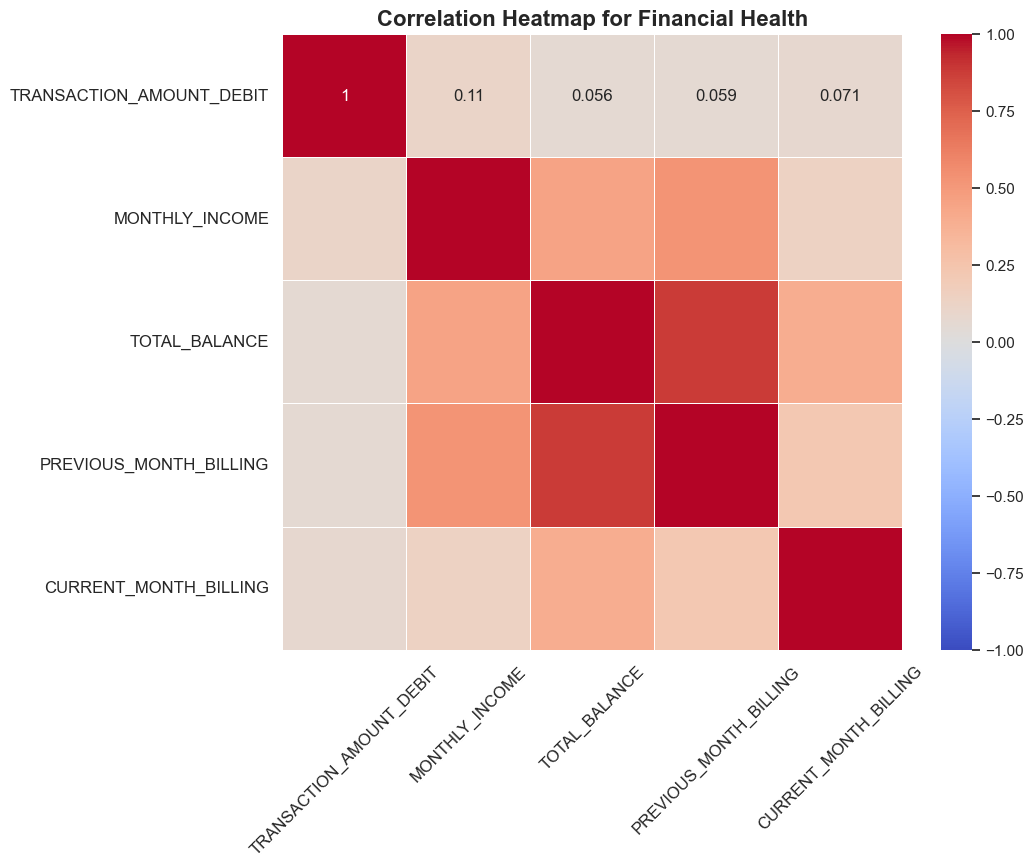

In [24]:
# Features for Financial Health concept
financial_health_features = ['TRANSACTION_AMOUNT_DEBIT', 'MONTHLY_INCOME', 'TOTAL_BALANCE','PREVIOUS_MONTH_BILLING', 'CURRENT_MONTH_BILLING']

# Compute the correlation matrix
corr_matrix = df[financial_health_features].corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5, annot_kws={"size": 12})

# Add titles and labels
plt.title('Correlation Heatmap for Financial Health', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, rotation=45)  # Slant the x-axis labels
plt.yticks(fontsize=12, rotation=0)

# Show the plot
plt.show()

In [25]:
# Identify pairs with correlation greater than 0.8
threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.index)):
    for j in range(len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Display the pairs with high correlation
print("Pairs with Correlation Coefficient > 0.8:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]}")

Pairs with Correlation Coefficient > 0.8:
TRANSACTION_AMOUNT_DEBIT and TRANSACTION_AMOUNT_DEBIT: 1.0
MONTHLY_INCOME and MONTHLY_INCOME: 1.0
TOTAL_BALANCE and TOTAL_BALANCE: 1.0
TOTAL_BALANCE and PREVIOUS_MONTH_BILLING: 0.8803108700640034
PREVIOUS_MONTH_BILLING and TOTAL_BALANCE: 0.8803108700640034
PREVIOUS_MONTH_BILLING and PREVIOUS_MONTH_BILLING: 1.0
CURRENT_MONTH_BILLING and CURRENT_MONTH_BILLING: 1.0


Resolving the redundancy between TOTAL_BALANCE and PREVIOUS_MONTH_BILLING: Since we are more interested in the customer's overall financial status, we can choose **TOTAL_BALANCE**. Hence,

In [26]:
financial_health_features = ['TRANSACTION_AMOUNT_DEBIT', 'MONTHLY_INCOME', 'TOTAL_BALANCE','CURRENT_MONTH_BILLING']

#### **Credit Reliability**

*Point Biserial Correlation*

In [27]:
# Features for Credit Reliability concept
credit_reliability_features = ['AUTO_LOAN_INDICATOR', 'HOUSING_LOAN_INDICATOR', 'SAVINGS_ACCOUNT_INDICATOR', 'DIGITAL_INDICATOR', 'REVOLVING_BALANCE', 'LOAN_BEHAVIOR', 'LOAN_AMOUNT']

# Initialize an empty correlation matrix
corr_matrix = pd.DataFrame(index=credit_reliability_features, columns=credit_reliability_features)

# Ensure that the binary variable is properly encoded as numeric values (0 and 1)
df['DIGITAL_INDICATOR'] = df['DIGITAL_INDICATOR'].map({'DIGITAL': 1, 'TRADITIONAL': 0})

# Convert LOAN_BEHAVIOR to ordinal ranks
loan_behavior_mapping = {'Amortization Past Due': 1, 'Items for litigation': 2, 'Current': 3, 'Principal Past Due': 4}
df['LOAN_BEHAVIOR'] = df['LOAN_BEHAVIOR'].map(loan_behavior_mapping)

# Compute correlations
for i in range(len(credit_reliability_features)):
    for j in range(i, len(credit_reliability_features)):
        if i == j:
            corr_matrix.iloc[i, j] = 1.0
        else:
            var1 = df[credit_reliability_features[i]]
            var2 = df[credit_reliability_features[j]]
            
            if var1.nunique() == 2 and var2.nunique() != 2:
                corr, _ = pointbiserialr(var1, var2)
            elif var2.nunique() == 2 and var1.nunique() != 2:
                corr, _ = pointbiserialr(var2, var1)
            else:
                corr, _ = pearsonr(var1, var2)
                
            corr_matrix.iloc[i, j] = corr
            corr_matrix.iloc[j, i] = corr

Correlation Matrix for Credit Reliability:
                           AUTO_LOAN_INDICATOR  HOUSING_LOAN_INDICATOR  \
AUTO_LOAN_INDICATOR                   1.000000               -0.198617   
HOUSING_LOAN_INDICATOR               -0.198617                1.000000   
SAVINGS_ACCOUNT_INDICATOR             0.125195               -0.450445   
DIGITAL_INDICATOR                     0.095525               -0.293474   
REVOLVING_BALANCE                    -0.041542                0.313268   
LOAN_BEHAVIOR                        -0.055924                0.045599   
LOAN_AMOUNT                           0.062031                0.664566   

                           SAVINGS_ACCOUNT_INDICATOR  DIGITAL_INDICATOR  \
AUTO_LOAN_INDICATOR                         0.125195           0.095525   
HOUSING_LOAN_INDICATOR                     -0.450445          -0.293474   
SAVINGS_ACCOUNT_INDICATOR                   1.000000           0.512814   
DIGITAL_INDICATOR                           0.512814           1

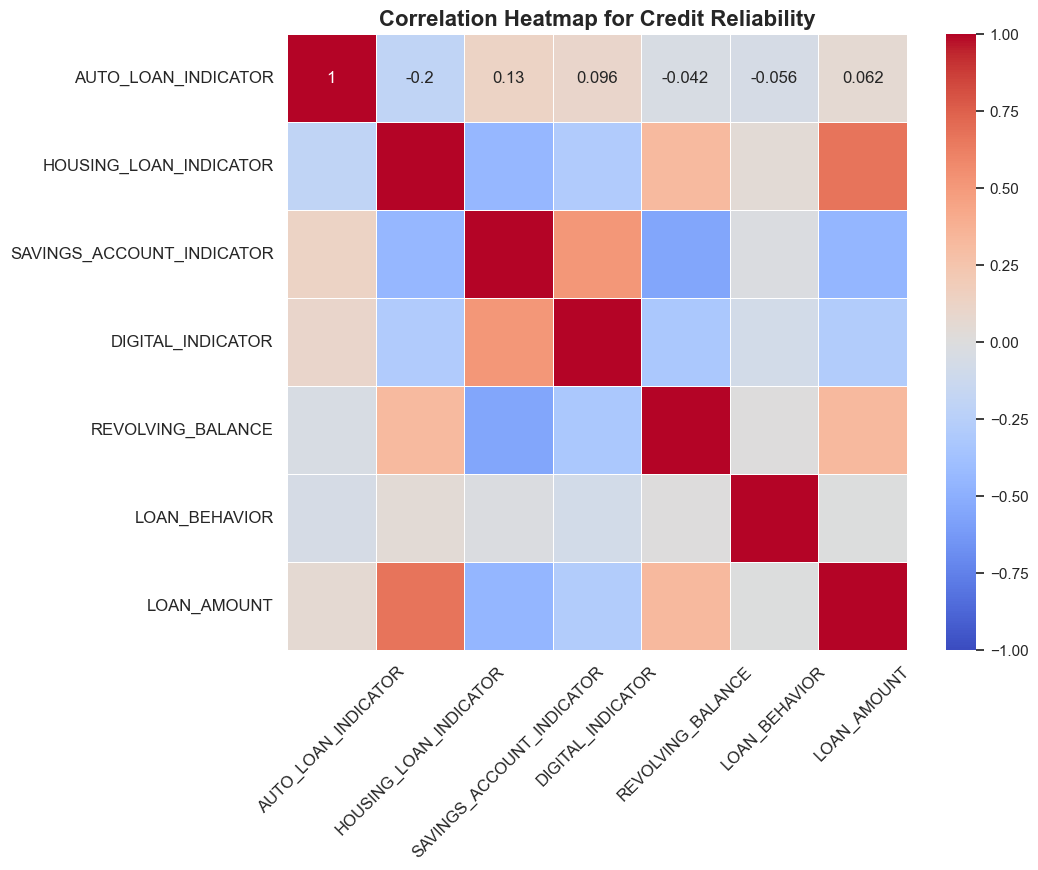

In [28]:
# Convert the correlation matrix to float
corr_matrix = corr_matrix.astype(float)

# Display the correlation matrix
print("Correlation Matrix for Credit Reliability:")
print(corr_matrix)

# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5, annot_kws={"size": 12})

# Add titles and labels
plt.title('Correlation Heatmap for Credit Reliability', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, rotation=45)  # Slant the x-axis labels
plt.yticks(fontsize=12, rotation=0)

# Show the plot
plt.show()

#### **Customer Engagement**

*Spearman Correlation*

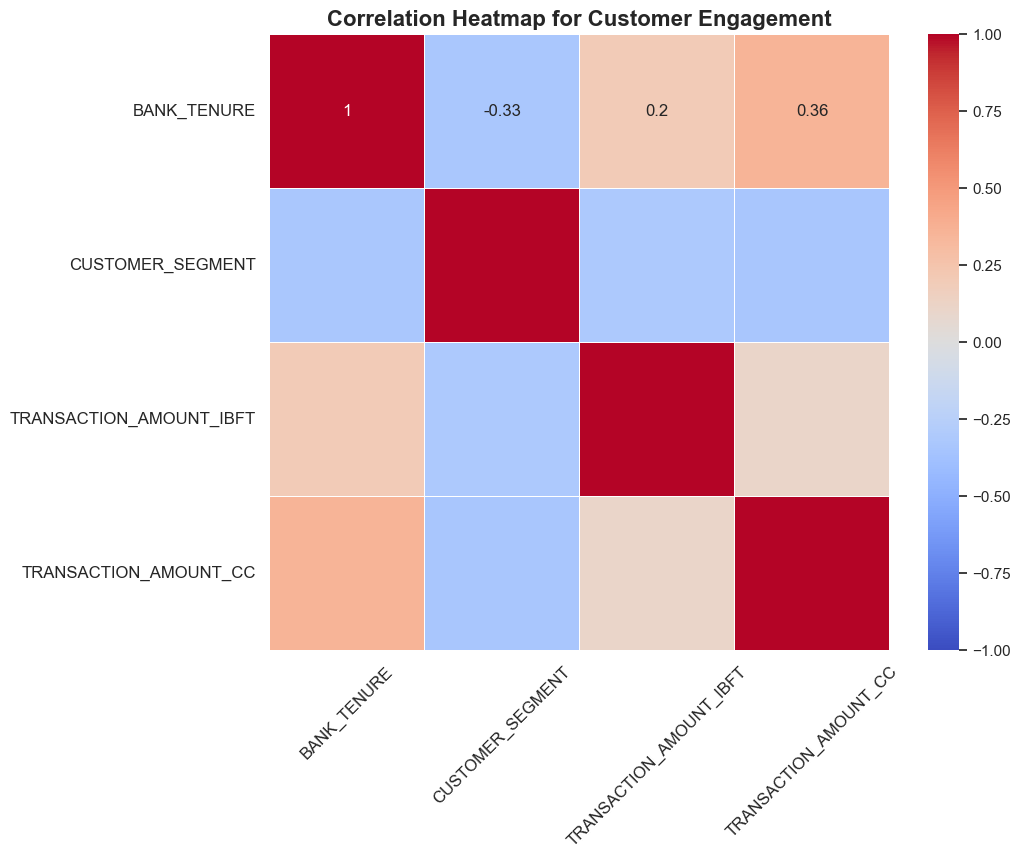

In [29]:
# Features for Customer Engagement concept
customer_engagement_features = ['BANK_TENURE', 'CUSTOMER_SEGMENT', 'TRANSACTION_AMOUNT_IBFT', 'TRANSACTION_AMOUNT_CC']

# Convert CUSTOMER_SEGMENT to ordinal ranks
segment_mapping = {'Tier 1': 1, 'Tier 2': 2, 'Tier 3': 3, 'Tier 4': 4, 'Tier 5': 5, 'Tier 6': 6}
df['CUSTOMER_SEGMENT'] = df['CUSTOMER_SEGMENT'].map(segment_mapping)

# Initialize an empty correlation matrix
corr_matrix = pd.DataFrame(index=customer_engagement_features, columns=customer_engagement_features)

# Compute correlations
for i in range(len(customer_engagement_features)):
    for j in range(i, len(customer_engagement_features)):
        if i == j:
            corr_matrix.iloc[i, j] = 1.0
        else:
            var1 = df[customer_engagement_features[i]]
            var2 = df[customer_engagement_features[j]]
            
            if customer_engagement_features[i] == 'CUSTOMER_SEGMENT' or customer_engagement_features[j] == 'CUSTOMER_SEGMENT':
                corr, _ = spearmanr(var1, var2)
            else:
                corr, _ = pearsonr(var1, var2)
                
            corr_matrix.iloc[i, j] = corr
            corr_matrix.iloc[j, i] = corr

# Convert the correlation matrix to float
corr_matrix = corr_matrix.astype(float)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5, annot_kws={"size": 12})

# Add titles and labels
plt.title('Correlation Heatmap for Customer Engagement', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, rotation=45)  # Slant the x-axis labels
plt.yticks(fontsize=12, rotation=0)

# Show the plot
plt.show()

#### **Socioeconomic Stability**

Correlation Matrix for Socioeconomic Stability:
                        SEC  CUSTOMER_LOCATION       AGE    GENDER  EDUCATION
SEC                1.000000           0.020737  0.365136  0.124763   0.105237
CUSTOMER_LOCATION  0.020737           1.000000  0.939287  0.262176  -0.007370
AGE                0.365136           0.939287  1.000000  0.192499   0.170249
GENDER             0.124763           0.262176  0.192499  1.000000   0.010954
EDUCATION          0.105237          -0.007370  0.170249  0.010954   1.000000
Pairs with Correlation Coefficient > 0.8:
AGE and CUSTOMER_LOCATION: 0.9392866650612691


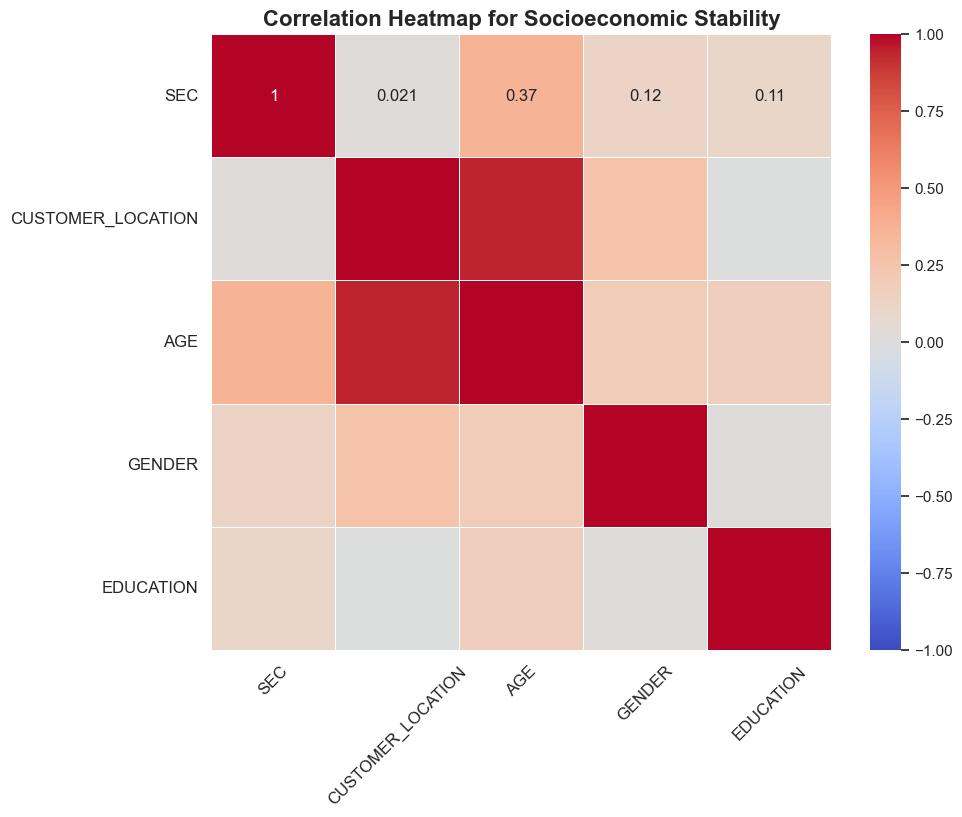

In [30]:
# Features for Socioeconomic Stability concept
socioeconomic_stability_features = ['SEC', 'CUSTOMER_LOCATION', 'AGE', 'GENDER', 'EDUCATION']

# Convert SEC to ordinal ranks
sec_mapping = {'E': 1, 'D': 2, 'C2': 3, 'C1': 4, 'B2': 5, 'B1': 6, 'A': 7}
df['SEC'] = df['SEC'].map(sec_mapping)

# Convert GENDER to binary values
df['GENDER'] = df['GENDER'].map({'MALE': 1, 'FEMALE': 0})

# Convert EDUCATION to ordinal ranks
education_mapping = {'LOW': 1, 'MID': 2, 'HIGH': 3}
df['EDUCATION'] = df['EDUCATION'].map(education_mapping)

# Function to compute Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Initialize an empty correlation matrix
corr_matrix = pd.DataFrame(index=socioeconomic_stability_features, columns=socioeconomic_stability_features)

# Compute correlations
for i in range(len(socioeconomic_stability_features)):
    for j in range(i, len(socioeconomic_stability_features)):
        if i == j:
            corr_matrix.iloc[i, j] = 1.0
        else:
            var1 = df[socioeconomic_stability_features[i]]
            var2 = df[socioeconomic_stability_features[j]]
            
            if socioeconomic_stability_features[i] in ['SEC', 'EDUCATION'] or socioeconomic_stability_features[j] in ['SEC', 'EDUCATION']:
                corr, _ = spearmanr(var1, var2)
            elif socioeconomic_stability_features[i] == 'CUSTOMER_LOCATION' or socioeconomic_stability_features[j] == 'CUSTOMER_LOCATION':
                corr = cramers_v(var1, var2)
            elif socioeconomic_stability_features[i] == 'GENDER' or socioeconomic_stability_features[j] == 'GENDER':
                corr, _ = pointbiserialr(var1, var2)
            else:
                corr, _ = pearsonr(var1, var2)
                
            corr_matrix.iloc[i, j] = corr
            corr_matrix.iloc[j, i] = corr

# Convert the correlation matrix to float
corr_matrix = corr_matrix.astype(float)

# Display the correlation matrix
print("Correlation Matrix for Socioeconomic Stability:")
print(corr_matrix)

# Identify pairs with correlation greater than 0.8
threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Display the pairs with high correlation
print("Pairs with Correlation Coefficient > 0.8:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]}")

# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5, annot_kws={"size": 12})

# Add titles and labels
plt.title('Correlation Heatmap for Socioeconomic Stability', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, rotation=45)  # Slant the x-axis labels
plt.yticks(fontsize=12, rotation=0)

# Show the plot
plt.show()

AGE and CUSTOMER_LOCATION have high correlation. We retain **CUSTOMER_LOCATION**.

In [31]:
socioeconomic_stability_features = ['SEC', 'CUSTOMER_LOCATION', 'GENDER', 'EDUCATION']

### **Check Cross-Concept Correlations for Distinctiveness**

In [32]:
df = combined_df.copy()

# Function to compute Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Initialize an empty correlation matrix for cross-concept correlations
cross_concept_corr_matrix = pd.DataFrame(index=financial_health_features + credit_reliability_features + customer_engagement_features, columns=socioeconomic_stability_features)

cross_concept_corr_matrix

,SEC,CUSTOMER_LOCATION,GENDER,EDUCATION
TRANSACTION_AMOUNT_DEBIT,NaN,NaN,NaN,NaN
MONTHLY_INCOME,NaN,NaN,NaN,NaN
TOTAL_BALANCE,NaN,NaN,NaN,NaN
CURRENT_MONTH_BILLING,NaN,NaN,NaN,NaN
AUTO_LOAN_INDICATOR,NaN,NaN,NaN,NaN
HOUSING_LOAN_INDICATOR,NaN,NaN,NaN,NaN
SAVINGS_ACCOUNT_INDICATOR,NaN,NaN,NaN,NaN
DIGITAL_INDICATOR,NaN,NaN,NaN,NaN
REVOLVING_BALANCE,NaN,NaN,NaN,NaN
LOAN_BEHAVIOR,NaN,NaN,NaN,NaN


In [33]:
# Convert SEC to ordinal ranks
sec_mapping = {'E': 1, 'D': 2, 'C2': 3, 'C1': 4, 'B2': 5, 'B1': 6, 'A': 7}
df['SEC'] = df['SEC'].map(sec_mapping)

# Convert GENDER to binary values
df['GENDER'] = df['GENDER'].map({'MALE': 1, 'FEMALE': 0}).astype(float)

# Convert EDUCATION to ordinal ranks
education_mapping = {'LOW': 1, 'MID': 2, 'HIGH': 3}
df['EDUCATION'] = df['EDUCATION'].map(education_mapping)

# Ensure that the binary variable is properly encoded as numeric values (0 and 1)
df['DIGITAL_INDICATOR'] = df['DIGITAL_INDICATOR'].map({'DIGITAL': 1, 'TRADITIONAL': 0})

# Convert LOAN_BEHAVIOR to ordinal ranks
loan_behavior_mapping = {'Amortization Past Due': 1, 'Items for litigation': 2, 'Current': 3, 'Principal Past Due': 4}
df['LOAN_BEHAVIOR'] = df['LOAN_BEHAVIOR'].map(loan_behavior_mapping)

# Convert CUSTOMER_SEGMENT to ordinal ranks
segment_mapping = {'Tier 1': 1, 'Tier 2': 2, 'Tier 3': 3, 'Tier 4': 4, 'Tier 5': 5, 'Tier 6': 6}
df['CUSTOMER_SEGMENT'] = df['CUSTOMER_SEGMENT'].map(segment_mapping)


In [34]:
# Compute cross-concept correlations
for i in range(len(cross_concept_corr_matrix.index)):
    for j in range(len(cross_concept_corr_matrix.columns)):
        var1 = df[cross_concept_corr_matrix.index[i]]
        var2 = df[cross_concept_corr_matrix.columns[j]]        
        
        if cross_concept_corr_matrix.columns[j] in ['SEC', 'EDUCATION']: #ordinal
            corr, _ = spearmanr(var1, var2)
        elif cross_concept_corr_matrix.columns[j] == 'CUSTOMER_LOCATION': #nominal
            corr = cramers_v(var1, var2)
        elif cross_concept_corr_matrix.columns[j] == 'GENDER': #binary
            corr, _ = pointbiserialr(var1, var2)
        else: #continuous
            corr, _ = pearsonr(var1, var2)
            
        cross_concept_corr_matrix.iloc[i, j] = corr

# Convert the correlation matrix to float
cross_concept_corr_matrix = cross_concept_corr_matrix.astype(float)

# Display the cross-concept correlation matrix
print(cross_concept_corr_matrix)

# Identify and retain indicators with low correlation (e.g., correlation coefficient < 0.3)
threshold = 0.3
low_corr_elements = cross_concept_corr_matrix[(cross_concept_corr_matrix < threshold) & (cross_concept_corr_matrix > -threshold)].dropna(how='all', axis=0).dropna(how='all', axis=1)

# Display the retained elements
print("Retained Elements with Correlation Coefficient < 0.3:")
print(low_corr_elements)

                                SEC  CUSTOMER_LOCATION    GENDER  EDUCATION
TRANSACTION_AMOUNT_DEBIT   0.321284           0.992215  0.046985   0.102530
MONTHLY_INCOME             0.938633           0.995925  0.315053   0.128049
TOTAL_BALANCE              0.109619           0.866467  0.130502   0.062437
CURRENT_MONTH_BILLING      0.063433           0.787454  0.047348   0.050295
AUTO_LOAN_INDICATOR        0.177611           0.207904  0.042769   0.079112
HOUSING_LOAN_INDICATOR     0.256532           0.218822  0.173424   0.051786
SAVINGS_ACCOUNT_INDICATOR -0.255774           0.519535 -0.238689  -0.023384
DIGITAL_INDICATOR         -0.049554           0.394676 -0.150585  -0.009015
REVOLVING_BALANCE          0.006595           0.718762  0.145472   0.041816
LOAN_BEHAVIOR              0.077208           0.370089 -0.041928  -0.000494
LOAN_AMOUNT                0.450233           0.949116  0.168674   0.169620
BANK_TENURE                0.378566           0.956085  0.174299   0.096586
CUSTOMER_SEG

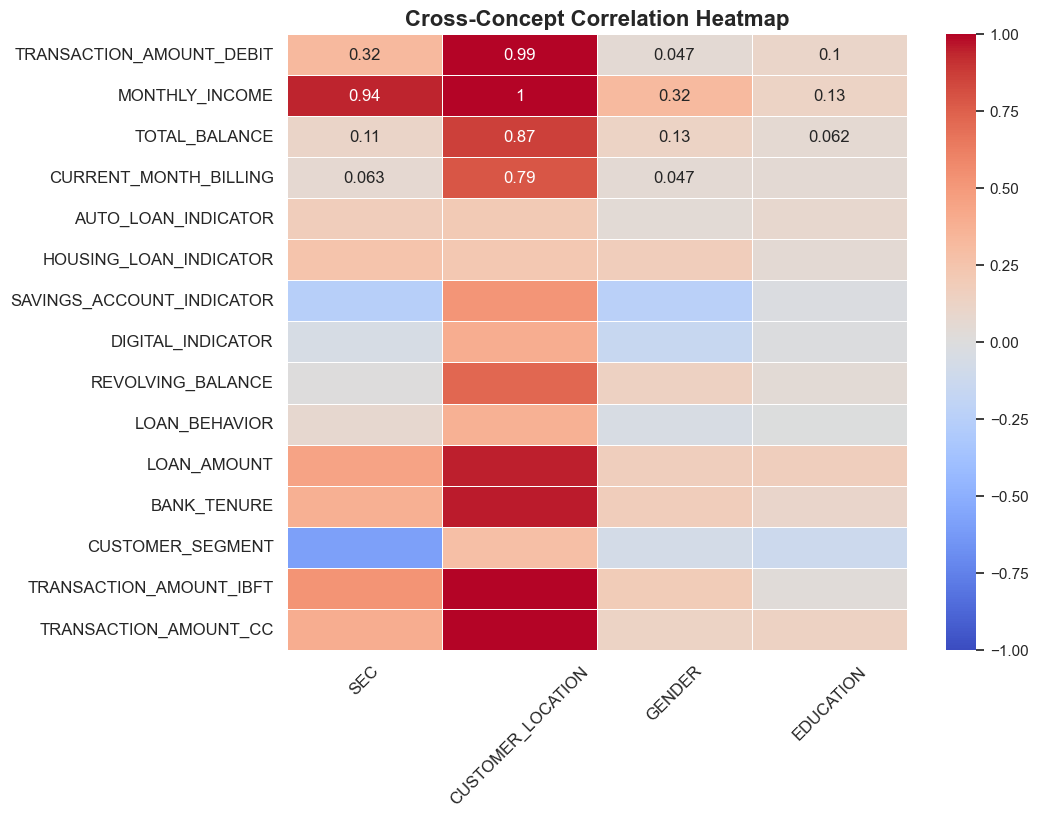

In [35]:
# Create a heatmap for the original cross-concept correlation matrix
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")
heatmap = sns.heatmap(cross_concept_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5, annot_kws={"size": 12})

# Add titles and labels
plt.title('Cross-Concept Correlation Heatmap', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, rotation=45)  # Slant the x-axis labels
plt.yticks(fontsize=12, rotation=0)

# Show the plot
plt.show()

In [36]:
# Identify pairs with correlation greater than 0.8
threshold = 0.8
high_corr_pairs = []

for i in range(len(cross_concept_corr_matrix.columns)):
    for j in range(i):
        if abs(cross_concept_corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((cross_concept_corr_matrix.columns[i], cross_concept_corr_matrix.columns[j], cross_concept_corr_matrix.iloc[i, j]))

# Display the pairs with high correlation
print("Pairs with Correlation Coefficient > 0.8:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]}")

Pairs with Correlation Coefficient > 0.8:
CUSTOMER_LOCATION and SEC: 0.9386328235357407
GENDER and CUSTOMER_LOCATION: 0.8664672454721847


Between CUSTOMER_LOCATION and SEC, we choose **SEC**. Hence, we have that

In [37]:
socioeconomic_stability_features = ['SEC', 'GENDER', 'EDUCATION']

### **Computation of the Overall Resilience Score**

The new set of features for each concept is as follows:

In [38]:
concepts = {
    "Financial Health": [
        'TRANSACTION_AMOUNT_DEBIT',
        'MONTHLY_INCOME',
        'TOTAL_BALANCE',
        'CURRENT_MONTH_BILLING'
 ],
    "Credit Reliability": [
        'AUTO_LOAN_INDICATOR',
        'HOUSING_LOAN_INDICATOR',
        'SAVINGS_ACCOUNT_INDICATOR',
        'DIGITAL_INDICATOR',
        'REVOLVING_BALANCE',
        'LOAN_BEHAVIOR',
        'LOAN_AMOUNT'
 ],
    "Customer Engagement": [
        'BANK_TENURE', 'CUSTOMER_SEGMENT', 'TRANSACTION_AMOUNT_IBFT', 
        'TRANSACTION_AMOUNT_CC'
    ],
    "Socioeconomic Stability": [
        'SEC', 'GENDER', 'EDUCATION'
    ]
}

In [39]:
df = df.drop_duplicates(subset=['CUSTOMER_ID', 'QUARTER'])

In [40]:
df_original = df.copy()
df_original = df_original.drop_duplicates()

df_original

,CUSTOMER_ID,BANK_TENURE,SEC,DIGITAL_INDICATOR,CUSTOMER_LOCATION,AGE,GENDER,EDUCATION,MONTHLY_INCOME,QUARTER,...,AUTO_LOAN_INDICATOR,HOUSING_LOAN_INDICATOR,SAVINGS_ACCOUNT_INDICATOR,CUSTOMER_SEGMENT,TOTAL_BALANCE,CURRENT_MONTH_BILLING,PREVIOUS_MONTH_BILLING,REVOLVING_BALANCE,LOAN_BEHAVIOR,LOAN_AMOUNT
0,1.758271e+07,27.25,5,1,NATIONAL CAPITAL REGION,53.92,0.0,2,128745.85,Q1 2024,...,0,0,3,1,0.53,0.53,0.53,0.53,3,95000.60
20,2.312157e+05,9.18,5,1,REGION III (CENTRAL LUZON),36.62,1.0,2,118438.34,Q1 2024,...,0,0,3,5,353624.11,230.21,114882.05,111081.71,3,60001.23
26,5.228743e+05,4.15,4,1,REGION IV-A (CALABARZON),33.94,0.0,2,49997.94,Q4 2023,...,0,0,3,5,78496.50,-0.86,20390.99,15366.81,3,29998.25
164,5.959871e+05,6.63,6,1,NATIONAL CAPITAL REGION,29.86,0.0,2,165346.22,Q1 2024,...,0,0,3,5,143247.22,1125.11,97886.63,95817.99,3,110000.20
200,6.099429e+05,18.87,7,1,NATIONAL CAPITAL REGION,48.08,0.0,2,250000.08,Q1 2024,...,0,3,3,1,34577.95,43067.74,41251.99,0.09,3,1541913.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79538,1.421496e+08,11.64,7,1,REGION IX (ZAMBOANGA PENINSULA),55.52,0.0,2,823078.35,Q4 2023,...,0,0,3,5,12310.79,4404.34,3979.68,2.34,3,21999.70
79574,1.422350e+08,3.72,4,1,NATIONAL CAPITAL REGION,37.23,1.0,2,40000.23,Q1 2024,...,0,0,3,5,-0.69,-0.69,-0.69,-0.69,3,45000.30
79646,1.422350e+08,3.72,4,1,NATIONAL CAPITAL REGION,37.23,1.0,2,40000.23,Q4 2023,...,0,0,3,5,-0.69,-0.69,-0.69,-0.69,3,45000.30
79718,1.423036e+08,6.69,7,1,NATIONAL CAPITAL REGION,51.14,1.0,2,267676.86,Q1 2024,...,3,0,3,3,415158.33,9662.20,412342.25,410132.08,3,1052000.05


We first standardize each selected indicator to a z-score and calculate composite scores.

In [41]:
for concept, features in concepts.items():
    df[features] = df[features].apply(zscore)
    df[f'{concept}_Score'] = df[features].mean(axis=1)

The code first applies the zscore function to each feature in the list of features for the current concept. The zscore function standardizes the features. This standardization is applied to ensure that all features are on the same scale, which is important for accurate score computation.

After standardizing the features, the code calculates the mean of the standardized features along the rows (axis=1) for each concept.

Then, combine concept scores into an overall resilience score.

In [42]:
df['Resilience_Score'] = df[[f'{concept}_Score' for concept in concepts]].mean(axis=1)

df

,CUSTOMER_ID,BANK_TENURE,SEC,DIGITAL_INDICATOR,CUSTOMER_LOCATION,AGE,GENDER,EDUCATION,MONTHLY_INCOME,QUARTER,...,CURRENT_MONTH_BILLING,PREVIOUS_MONTH_BILLING,REVOLVING_BALANCE,LOAN_BEHAVIOR,LOAN_AMOUNT,Financial Health_Score,Credit Reliability_Score,Customer Engagement_Score,Socioeconomic Stability_Score,Resilience_Score
0,1.758271e+07,2.988175,-0.49432,0.356378,NATIONAL CAPITAL REGION,53.92,-0.776313,0.116178,-0.257990,Q1 2024,...,-0.431052,0.53,-0.402689,0.183322,-0.507883,-0.168113,-0.163146,-0.007070,-0.384818,-0.180787
20,2.312157e+05,-0.238484,-0.49432,0.356378,REGION III (CENTRAL LUZON),36.62,1.288141,0.116178,-0.269803,Q1 2024,...,-0.424265,114882.05,1.135097,0.183322,-0.547986,0.319507,0.050808,-0.184378,0.303333,0.122317
26,5.228743e+05,-1.136663,-1.26744,0.356378,REGION IV-A (CALABARZON),33.94,-0.776313,0.116178,-0.348242,Q4 2023,...,-0.431093,20390.99,-0.189961,0.183322,-0.582364,-0.295552,-0.143397,-0.417785,-0.642525,-0.374815
164,5.959871e+05,-0.693823,0.27880,0.356378,NATIONAL CAPITAL REGION,29.86,-0.776313,0.116178,-0.216043,Q1 2024,...,-0.397819,97886.63,0.923789,0.183322,-0.490696,-0.131962,0.028806,-0.284533,-0.127111,-0.128700
200,6.099429e+05,1.491805,1.05192,0.356378,NATIONAL CAPITAL REGION,48.08,-0.776313,0.116178,-0.119022,Q1 2024,...,0.841651,41251.99,-0.402695,0.183322,1.150024,0.009247,0.601817,-0.162482,0.130595,0.144794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79538,1.421496e+08,0.200784,1.05192,0.356378,REGION IX (ZAMBOANGA PENINSULA),55.52,-0.776313,0.116178,0.537776,Q4 2023,...,-0.300913,3979.68,-0.402664,0.183322,-0.591529,-0.115448,-0.175092,0.224702,0.130595,0.016189
79574,1.422350e+08,-1.213446,-1.26744,0.356378,NATIONAL CAPITAL REGION,37.23,1.288141,0.116178,-0.359700,Q1 2024,...,-0.431088,-0.69,-0.402706,0.183322,-0.565175,-0.448922,-0.171333,-0.303097,0.045626,-0.219431
79646,1.422350e+08,-1.213446,-1.26744,0.356378,NATIONAL CAPITAL REGION,37.23,1.288141,0.116178,-0.359700,Q4 2023,...,-0.431088,-0.69,-0.402706,0.183322,-0.565175,-0.447447,-0.171333,-0.439556,0.045626,-0.253177
79718,1.423036e+08,-0.683109,1.05192,0.356378,NATIONAL CAPITAL REGION,51.14,1.288141,0.116178,-0.098763,Q1 2024,...,-0.145535,412342.25,5.275091,0.183322,0.588670,0.620191,1.138290,0.190030,0.818746,0.691814


In [43]:
df['Resilience_Score'].describe()

count    843.000000
mean       0.000000
std        0.350929
min       -0.977675
25%       -0.213612
50%       -0.060818
75%        0.141202
max        3.144448
Name: Resilience_Score, dtype: float64

This is not easily interpretable. Let's rescale Resilience Score.

In [44]:
from sklearn.preprocessing import MinMaxScaler

# Assuming df is already defined and contains the necessary data

# Define the features for each concept
concepts = {
    "Financial Health": [
        'TRANSACTION_AMOUNT_DEBIT', 'MONTHLY_INCOME', 'TOTAL_BALANCE', 'CURRENT_MONTH_BILLING'
    ],
    "Credit Reliability": [
        'AUTO_LOAN_INDICATOR', 'HOUSING_LOAN_INDICATOR', 
        'SAVINGS_ACCOUNT_INDICATOR', 'DIGITAL_INDICATOR', 'REVOLVING_BALANCE', 'LOAN_BEHAVIOR', 'LOAN_AMOUNT'
    ],
    "Customer Engagement": [
        'BANK_TENURE', 'CUSTOMER_SEGMENT', 'TRANSACTION_AMOUNT_IBFT', 
        'TRANSACTION_AMOUNT_CC'
    ],
    "Socioeconomic Stability": [
        'SEC', 'CUSTOMER_LOCATION', 'AGE', 'GENDER', 'EDUCATION'
    ]
}

# Rescale the scores to a range of 0 to 1
scaler = MinMaxScaler()
scores = ['Financial Health_Score', 'Credit Reliability_Score', 'Customer Engagement_Score', 'Socioeconomic Stability_Score', 'Resilience_Score']
df[scores] = scaler.fit_transform(df[scores])

In [45]:
df.to_csv('Resilience Score Analysis DF.csv', index=False)

In [46]:
df.columns

Index(['CUSTOMER_ID', 'BANK_TENURE', 'SEC', 'DIGITAL_INDICATOR',
       'CUSTOMER_LOCATION', 'AGE', 'GENDER', 'EDUCATION', 'MONTHLY_INCOME',
       'QUARTER', 'TRANSACTION_AMOUNT_DEBIT', 'TRANSACTION_AMOUNT_CC',
       'TRANSACTION_AMOUNT_IBFT', 'AUTO_LOAN_INDICATOR',
       'HOUSING_LOAN_INDICATOR', 'SAVINGS_ACCOUNT_INDICATOR',
       'CUSTOMER_SEGMENT', 'TOTAL_BALANCE', 'CURRENT_MONTH_BILLING',
       'PREVIOUS_MONTH_BILLING', 'REVOLVING_BALANCE', 'LOAN_BEHAVIOR',
       'LOAN_AMOUNT', 'Financial Health_Score', 'Credit Reliability_Score',
       'Customer Engagement_Score', 'Socioeconomic Stability_Score',
       'Resilience_Score'],
      dtype='object')

In [47]:
# Remove duplicates based on CUSTOMER_ID and QUARTER in both dataframes
df_original = df_original.drop_duplicates(subset=['CUSTOMER_ID', 'QUARTER'])
df = df.drop_duplicates(subset=['CUSTOMER_ID', 'QUARTER'])

# Select only the new columns and the keys from df
df_new_columns = df[['CUSTOMER_ID', 'QUARTER', 'Financial Health_Score', 'Credit Reliability_Score',
                     'Customer Engagement_Score', 'Socioeconomic Stability_Score', 'Resilience_Score']]

# Merge df_original with the new columns from df
df_merged = df_original.merge(df_new_columns, on=['CUSTOMER_ID', 'QUARTER'], how='left')

df_merged

,CUSTOMER_ID,BANK_TENURE,SEC,DIGITAL_INDICATOR,CUSTOMER_LOCATION,AGE,GENDER,EDUCATION,MONTHLY_INCOME,QUARTER,...,CURRENT_MONTH_BILLING,PREVIOUS_MONTH_BILLING,REVOLVING_BALANCE,LOAN_BEHAVIOR,LOAN_AMOUNT,Financial Health_Score,Credit Reliability_Score,Customer Engagement_Score,Socioeconomic Stability_Score,Resilience_Score
0,1.758271e+07,27.25,5,1,NATIONAL CAPITAL REGION,53.92,0.0,2,128745.85,Q1 2024,...,0.53,0.53,0.53,3,95000.60,0.029382,0.521336,0.233771,0.445586,0.193320
1,2.312157e+05,9.18,5,1,REGION III (CENTRAL LUZON),36.62,1.0,2,118438.34,Q1 2024,...,230.21,114882.05,111081.71,3,60001.23,0.079303,0.589853,0.194828,0.619570,0.266851
2,5.228743e+05,4.15,4,1,REGION IV-A (CALABARZON),33.94,0.0,2,49997.94,Q4 2023,...,-0.86,20390.99,15366.81,3,29998.25,0.016336,0.527661,0.143564,0.380430,0.146250
3,5.959871e+05,6.63,6,1,NATIONAL CAPITAL REGION,29.86,0.0,2,165346.22,Q1 2024,...,1125.11,97886.63,95817.99,3,110000.20,0.033083,0.582807,0.172830,0.510741,0.205956
4,6.099429e+05,18.87,7,1,NATIONAL CAPITAL REGION,48.08,0.0,2,250000.08,Q1 2024,...,43067.74,41251.99,0.09,3,1541913.45,0.047540,0.766308,0.199637,0.575897,0.272304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,1.421496e+08,11.64,7,1,REGION IX (ZAMBOANGA PENINSULA),55.52,0.0,2,823078.35,Q4 2023,...,4404.34,3979.68,2.34,3,21999.70,0.034774,0.517510,0.284676,0.575897,0.241105
839,1.422350e+08,3.72,4,1,NATIONAL CAPITAL REGION,37.23,1.0,2,40000.23,Q1 2024,...,-0.69,-0.69,-0.69,3,45000.30,0.000634,0.518714,0.168753,0.554414,0.183945
840,1.422350e+08,3.72,4,1,NATIONAL CAPITAL REGION,37.23,1.0,2,40000.23,Q4 2023,...,-0.69,-0.69,-0.69,3,45000.30,0.000785,0.518714,0.138782,0.554414,0.175758
841,1.423036e+08,6.69,7,1,NATIONAL CAPITAL REGION,51.14,1.0,2,267676.86,Q1 2024,...,9662.20,412342.25,410132.08,3,1052000.05,0.110086,0.938108,0.277061,0.749882,0.405007


In [48]:
df_merged.to_csv('Resilience Score Analysis Unscaled.csv', index=False)